In [ ]:
!pip install tensorflow_text

In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [2]:
df = pd.read_csv('quora.csv', index_col='Unnamed: 0')
inst_df = df[['question1','question2','is_duplicate']]
inst_df.head()

,question1,question2,is_duplicate
0,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,How close we are to see 3rd world war?,How close is a World War III?,1


In [ ]:
inst_df.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

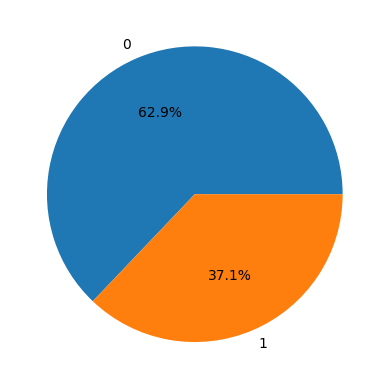

In [3]:
plt.pie( inst_df.is_duplicate.value_counts(),labels=df.is_duplicate.unique(),autopct='%.1f%%')
plt.show()

## Number of total rows is about 1,00,000. So reducing the Class 0 in inst_df

In [4]:
newdf= inst_df[inst_df['is_duplicate']==0]
newdf.count()
newdf=newdf.sample(frac=1,random_state=1).reset_index(drop=True)
newdf = newdf[:int(len(newdf)*0.08)]
newdf.count()

question1       5030
question2       5030
is_duplicate    5030
dtype: int64

In [5]:
newdf1= inst_df[inst_df['is_duplicate']==1]
newdf1.count()
newdf1=newdf1.sample(frac=1, random_state=1).reset_index(drop=True)
newdf1 = newdf1[:int(len(newdf1)*0.135)]
newdf1.count()

question1       5011
question2       5011
is_duplicate    5011
dtype: int64

In [6]:
final_df = pd.concat([newdf1,newdf])
final_df.sample(frac=1,random_state=10).reset_index(drop=True)
final_df.head()

,question1,question2,is_duplicate
0,How do I deal with social anxiety disorder?,How do I deal with my social anxiety?,1
1,How can I recover my Hotmail password?,How do I recover my Hotmail password?,1
2,Can I please get a crown on musical.ly?,How do you get a crown in Musical.ly?,1
3,How do I start a new life in a new Country?,Where can I start a new life in new country ea...,1
4,What are must have apps?,What are some of the must-have apps?,1


In [7]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [8]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_inputs = preprocessor(text_input)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
embedding_model = tf.keras.Model(text_input, pooled_output)

In [ ]:
l= []
with tf.device('/gpu:0'):
    sentences = tf.constant(np.asarray(final_df['question1']).reshape(final_df['question1'].shape[0],1))
    l=embedding_model(sentences)

In [13]:
l=[]
for i in tqdm(final_df['question1']):
    sentence = tf.constant([i])
    l.append(embedding_model(sentence)[0][:])

100%|████████████████████████████████████████████████████████████████████████████| 10041/10041 [35:38<00:00,  4.70it/s]


In [22]:
q1 = np.array(l)
q1.shape

(10041, 768)

In [23]:
np.savetxt('q2_transformed.csv', q1, delimiter=',')

In [21]:
l=[]
for i in tqdm(final_df['question2']):
    sentence = tf.constant([i])
    l.append(embedding_model(sentence)[0][:])

100%|████████████████████████████████████████████████████████████████████████████| 10041/10041 [23:20<00:00,  7.17it/s]


## Loading transfromed data from csv to np for cosine similarity 

In [34]:
q1 = np.loadtxt('q1_transformed.csv', delimiter=',')
q2 = np.loadtxt('q2_transformed.csv', delimiter=',')
q2.shape

(10041, 768)

In [73]:
a=[]
for i,j in tqdm(zip(q1, q2)):
    a.append(round(cosine_similarity(i.reshape(1, len(i)), j.reshape(1,len(j)))[0][0],2))

10041it [00:01, 6548.39it/s]


In [82]:
y = np.array(final_df.is_duplicate).reshape(len(a),1)
np_cosine=np.array(a).reshape(len(a),1)
n = np.concatenate((np_cosine, y), axis=1)
n.shape

(10041, 2)

In [86]:
df_Final = pd.DataFrame(n, columns=["cosineValue","class"])
df_Final.tail()

,cosineValue,class
10036,0.96,0.0
10037,0.94,0.0
10038,0.97,0.0
10039,1.00,0.0
10040,0.94,0.0


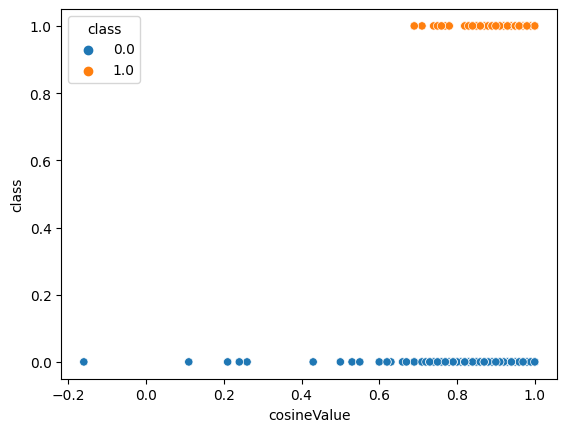

In [116]:
sns.scatterplot(data=df_Final, x= 'cosineValue',y= 'class',hue='class')
plt.show()

# Upon obeserving the result of cosine similarity, it is advisible to make another column 
# based upon following condition, if( cosine_similaity < 0.7 then it surely a non dulicate question pair else there is a doubt) 